In [24]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from torchtext.vocab import Vocab
from collections import Counter

from kagglehub import KaggleDatasetAdapter
    
warnings.filterwarnings("ignore")

# # !pip3 install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # # !pip uninstall torch torchvision torchaudio -y


In [26]:
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print(torch.__version__)

2.3.0


In [27]:
print("Path to dataset files:", path)

Path to dataset files: /Users/aman/.cache/kagglehub/datasets/venky73/spam-mails-dataset/versions/1


In [29]:

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

device = torch.device("mps")
    
    


GPU not available, CPU used


In [8]:
csv = os.path.join(path, "spam_ham_dataset.csv")
print(csv)

/Users/aman/.cache/kagglehub/datasets/venky73/spam-mails-dataset/versions/1/spam_ham_dataset.csv


In [11]:
# if os.path.exists(csv):
#     print("File Exists")
# else:
#     print("File doesn't exist")


In [12]:
data = pd.read_csv(csv)
data.sample(n = 100)

,Unnamed: 0,label,text,label_num
1630,4541,spam,Subject: hey !\r\nhi ! i am looking for new fr...,1
1034,3698,spam,Subject: weekend entertainment\r\nalpha male p...,1
173,754,ham,Subject: well head\r\nshoreline wants to incre...,0
3853,2734,ham,"Subject: hpl nom for march 16 , 2001\r\n( see ...",0
2899,2311,ham,"Subject: hpl noms - dec . 30 - 31 , 2000 and j...",0
...,...,...,...,...
2969,4516,spam,"Subject: paliourg , enl 4 rge your penls now !...",1
945,1259,ham,Subject: eastrans - lst of month nomination - ...,0
2844,5077,spam,Subject: ? ? ? ? 13 ? ? ? ? ? ? ? * ? * ? * ?\...,1
3773,3482,ham,Subject: fw : candle lighting\r\n- - - - - ori...,0


In [13]:
data.info()


print("------------------------")

only_text = data[["text","label_num"]]

only_text.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
------------------------


,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [14]:
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [15]:
text_length = len(only_text) 


In [16]:
from sklearn.model_selection import train_test_split
import re

import torch

# Sample string
# text = "hello world hello"

# # Tokenization and vocabulary creation
# tokens = text.split()
# print(tokens)
# vocab = {token: index for index, token in enumerate(sorted(set(tokens)))}
# print(vocab)
# # Numerical encoding
# encoded_text = [vocab[token] for token in tokens]
# print(encoded_text)

# # Tensor creation
# text_tensor = torch.tensor(encoded_text)

# print(text_tensor)
# # Expected output: tensor([0, 1, 0])

def pre_processing(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = text.replace('subject', '')
    
    tokenizer = get_tokenizer("basic_english")
    
    tokens = tokenizer(text)
    
    
    vocab = {token: index for index, token in enumerate(sorted(set(tokens)))}
    
    encoded_text = [vocab[token] for token in tokens]
    
    text_tensor = torch.tensor(encoded_text)

    
    # # Numerical encoding
    # encoded_text = [vocab[token] for token in tokens]
      
    return text_tensor
  

def build_vocab(text):
  counter.update(text)

counter = Counter()

print(pre_processing("Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."))

data["processed"] = data["text"].apply(pre_processing)

data["processed"].apply(build_vocab)

min_freq = 3
filtered_counter = Counter({word: count for word, count in counter.items() if count >= min_freq})
vocab = counter


print(len(filtered_counter))

data.head()

tensor([11, 21, 20, 37, 19,  0, 13, 39, 38, 36, 24, 18, 17, 41, 26, 22, 30, 12,
         9, 32,  3,  8, 28, 27, 29, 35,  7, 40, 31, 42, 38, 34,  7,  1, 41,  4,
        25, 15, 16,  6, 37,  5, 19, 23,  2, 14, 10, 33])
0


,Unnamed: 0,label,text,label_num,processed
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[tensor(11), tensor(21), tensor(20), tensor(37..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[tensor(3), tensor(6), tensor(2), tensor(5), t..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[tensor(119), tensor(151), tensor(82), tensor(..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[tensor(28), tensor(42), tensor(25), tensor(9)..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[tensor(29), tensor(17), tensor(33), tensor(39..."


In [17]:
set_train_Parameters = data.iloc[:int(0.8 * len(data))]

set_test_Parameters = data.iloc[int((0.8) * len(data)):]

training_data = set_train_Parameters[["processed", "label_num"]]

test_data = set_test_Parameters[["processed", "label_num"]]

training_data_no_proccess = set_train_Parameters[["text", "label_num"]]

test_data_no_proccess = set_test_Parameters[["text", "label_num"]]


print(len(training_data_no_proccess))
print(len(test_data_no_proccess))
training_data.head()


4136
1035


,processed,label_num
0,"[tensor(11), tensor(21), tensor(20), tensor(37...",0
1,"[tensor(3), tensor(6), tensor(2), tensor(5), t...",0
2,"[tensor(119), tensor(151), tensor(82), tensor(...",0
3,"[tensor(28), tensor(42), tensor(25), tensor(9)...",1
4,"[tensor(29), tensor(17), tensor(33), tensor(39...",0


Text(0, 0.5, 'Count')

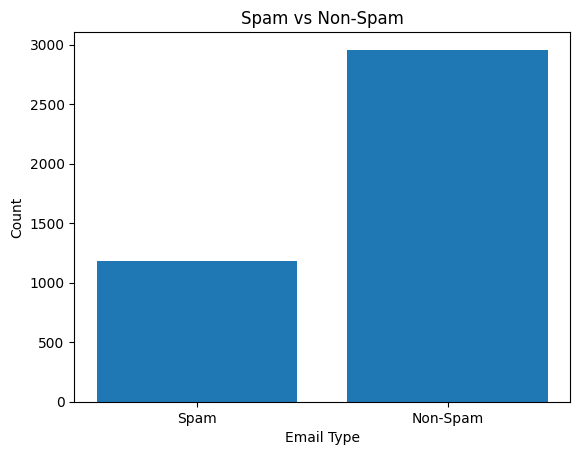

In [18]:
spam_count = training_data_no_proccess["label_num"].value_counts()[1]
non_spam_count = training_data_no_proccess["label_num"].value_counts()[0]

plt.bar(["Spam", "Non-Spam"], [spam_count, non_spam_count])
plt.title("Spam vs Non-Spam")
plt.xlabel("Email Type")
plt.ylabel("Count")

In [19]:
class SpamDataset(Dataset):
    def __init__(self, df):
        self.processed_texts = df["processed"].tolist()  
        self.labels = df["label_num"].tolist()
       
    def __len__(self):
        return len(self.processed_texts)

    def __getitem__(self,idx):
        # Convert tokens to indices
        tokens = self.processed_texts[idx]
        
        label = self.labels[idx]
        
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)
        


train_datasets = SpamDataset(training_data)
test_datasets = SpamDataset(test_data)

print(train_datasets.__getitem__(0))



(tensor([11, 21, 20, 37, 19,  0, 13, 39, 38, 36, 24, 18, 17, 41, 26, 22, 30, 12,
         9, 32,  3,  8, 28, 27, 29, 35,  7, 40, 31, 42, 38, 34,  7,  1, 41,  4,
        25, 15, 16,  6, 37,  5, 19, 23,  2, 14, 10, 33]), tensor(0))


In [20]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        last_hidden = output[:, -1, :]
        logits = self.fc(last_hidden)
        return logits

def collate_fn(batch):
    texts, labels = zip(*batch)
    # Pad sequences to the same length
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return texts_padded, labels 




In [22]:
learning_rate = 0.001
num_epochs = 3
batch_size = 32
num_classes = 2
VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)
EMBED_DIM = 128
HIDDEN_DIM = 64

model = TextClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, num_classes)
model.to(device)
print(model)
print(next(model.parameters()).is_cuda)


train_dataloader = DataLoader(train_datasets, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=False, collate_fn=collate_fn)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for text_batch, label_batch in train_dataloader:
        optimizer.zero_grad()
        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)        
        outputs = model(text_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


761072
TextClassifier(
  (embedding): Embedding(761072, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
False
Epoch 1, Loss: 0.6256
Epoch 2, Loss: 0.4684
Epoch 3, Loss: 0.3473


In [ ]:
model.eval()
print(next(model.parameters()).is_cuda)

def test(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_data)
    accuracy = 100 * correct / len(test_dataloader.dataset)
    return test_loss, accuracy

test_loss, accuracy = test(model, test_dataloader)

print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {accuracy:.2f}%')

NameError: name 'model' is not defined

In [2]:

# Download latest version
path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.86M/2.86M [00:00<00:00, 11.9MB/s]

Extracting files...
Path to dataset files: C:\Users\amann\.cache\kagglehub\datasets\jackksoncsie\spam-email-dataset\versions\1


In [8]:
csv = os.path.join(path, "emails.csv")
print(csv)

C:\Users\amann\.cache\kagglehub\datasets\jackksoncsie\spam-email-dataset\versions\1\emails.csv


In [9]:
if os.path.exists(csv):
    print("File Exists")
else:
    print("File doesn't exist")

File Exists


In [ ]:
new_data = pd.read_csv(csv)
new_data.sample(n = 100)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [ ]:
new_test_dataLoader = DataLoader(new_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

test(model, new_test_dataLoader)
